 # Bayesian inference and MCMC : my understanding of the theory explained with Python scripts


Some basics to have to follow this tutorial :
- Basic python skills
- Probabilities : density function
- Other maths : integrals

Disclaimer : I am not an expert in math, this tutorial may help you understand MCMC and Bayesian inference but will not be a sound basis to understand the mathematical theory or Markov Chains or any other stuff.

In [13]:
# Some libraries 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, expon, norm, multivariate_normal
import time
from markov import MarkovChain # Find at https://github.com/NaysanSaran/markov-chain
import seaborn as sns
import pandas as pd

## A. Introduction to Bayesian inference

Inspired by the course of M.L. Delignette-Muller "Introduction to Bayesian Inference" for VetAgroSup.

### 1. Bayesian inference  vs Frequentist inference
This part will not be exhaustive at all, it is a subject prone to debate.

Different views of what is a probability :
- In a frequentist perspective, the probability of an event is defined as the fraction of times that the event occurs in a very large number of trials.
- In a bayesian prespective, the probability is seen as a degree of belief, a measure of uncertainty.

Inference refers to the fit of the model to the data. The model refers to a process that generates observed data Y. It could depend on known covariates X. For example the most simple model will be Y=X. But usually a model will have a stochastic part as well as unknown parameters $\theta$. The goal of inference will be to estimate $\theta$.

- For frequentist inference : the parameter $\theta$ is assumed fixed but unknown. It is estimated using methods like :
    - Moment matching
    - Maximum likelihood
    - Sum of squared deviations minimization 
- Bayesian inference : the parameter $\theta$ is supposed uncertain and its uncertainty is characerized by a probability distribution (a degree of belief). This distribution is estimated using Bayes theorem.

#### Frequentist inference : confidence interval and p-value

Three results are of interest for frequentist inference :
- The point estimate
- the confidence interval
- hypothesis test with p-value

The **confidence interval** is based on imagining repeated sampling from the model. If we repeatedly obtained samples of size n from the population and constructed a 95% confidence interval for each, we could expect 95% of the intervals to contain the true value of the parameter. Note that it does not mean that it does not mean that the parameter has a 95% chance of being in the interval as precisely in the frequentist framework, such probability does not exists. **p-value** will not be discussed here, but the interpretation of p-values must be very careful and the intepretation is not straightforward. 

#### Bayesian inference : distribution and credible interval

The Bayesian inference obtains a posterior distribution of $\theta$.

To obtain a point estimate of the parameters, we would consider the mean or the median for example. Credible intervals (sometimes loosly refered to as confidence interval) are drawn from the posterior distribution quantiles. It is easier to interpret than a confidence interval. 

There is no need to have an equivalent of hypothesis testing. The distributions carries all the information we could need about the uncertainty of our estimation.


### 2. Bayesian inference in practice

First we need a prior distributions P($\theta$). Let's note here that P will be a density in our case. If you have no information about the prior, distributions like the uniform distributions are considered uninformative. Then you can apply the Bayes formula to obtain the posterior distribution :

$$P(\theta \mid Y)=\frac{P(Y \mid \theta) \times P(\theta)}{P(Y)} \propto P(Y \mid \theta) \times P(\theta)$$

An analytical result only exists in some cases. It is the reason why it is hard for most cases to apply Bayesian inference. MCMC allows to draw samples from complex analytical expressions. 

- $P(Y \mid \theta)$ is the likelihood
- $P(\theta)$ is the prior
- $P(Y)$ is the evidence but it is not necessary to compute it since it is a constant.
- $P(\theta \mid Y)$ is the posterior distribution we want to obtain

An interesting mecanism of bayesian inference is that if we have the data Y = [y1, ..., yn] and if we alread have the posterior $P(\theta \mid [y2, ...,yn])$ : 
$$P(\theta \mid Y) \propto P(y1 \mid \theta) \times P(\theta \mid [y2, ...,yn])$$

This formula means that we can iterate by considering our posterior as our new prior. 

Another way to see it is that the likelihood is : $P(Y \mid \theta)=\prod_i P(yi \mid \theta)$

#### Example of bayesian inference

This example is copied from : https://datapythonista.me/blog/bayesian-inference-tutorial-a-hello-world-example.html

The problem is to approximate the mean and the variance of a normal law that represent the distribution of heights in a human population like say for example pyton programmers. We have the data points : [183, 168, 177, 170, 175, 177, 178, 166, 174, 178].

In this case, we have directly the likelihood for one measure. It is our model.

$$P(x \mid \mu, \sigma)=\frac{1}{\sqrt{2 \pi \sigma^{2}}} \cdot e^{-\frac{(x-\mu)^{2}}{2 \sigma^{2}}}$$

An example of prior could be based on the world population :
- uniform [0,300] for mean
- uniform [2,20] for std

We can obtain a first posterior evaluation for a theta with : $$P(\mu, \sigma \mid x1) \propto P(x1 \mid \mu, \sigma)P(\mu, \sigma)$$

Then we iterate to obtain : $$P(\mu, \sigma \mid x1,x2) \propto P(x2 \mid \mu, \sigma)P(\mu, \sigma \mid x1)$$

We repeat this n times to only obtain one value of the posterior. As said before the other way to see this is that we compute the total likelihood like the product of the marginal likelihoods.

>In general we can sum up the calculus of the posterior like this :
>
>$$P(\theta \mid Y) \propto P(Y \mid \theta) \times P(\theta) = \prod_i P(yi \mid \theta)\times P(\theta)$$

In our case the expression of the likelihood is straightforward but it is not always the case. 

In [140]:
data_h = np.array([183, 168, 177, 170, 175, 177, 178, 166, 174, 178])

def get_posterior(theta, data_h, prior, likelihood):
    posterior = prior(theta)
    likelihoods = likelihood(data_h, theta)
    for i in range(len(data_h)):
        posterior = likelihoods[i]*posterior
    return posterior

def compute_posteriors(mu_candidates, sigma_candidates, data_h, prior, likelihood):
    for mu in mu_candidates:
        for sigma in sigma_candidates:
            yield mu, sigma, get_posterior([mu, sigma], data_h, prior, likelihood)
            
def get_heatmap(res):
    results = pd.DataFrame(res, columns=('mu', 'sigma', 'posterior')).set_index(['mu', 'sigma'])['posterior']
    mu_max,sigma_max = results.idxmax()
    max_posterior = results[(mu_max,sigma_max)]
    print('mu(max_posterior) : {}'.format(mu_max))
    print('sigma(max_posterior) : {}'.format(mu_max))
    print('max_posterior : {}'.format(max_posterior))
    heatmap_results = results.unstack(-1)
    heatmap_results.index = heatmap_results.index.astype(int)
    heatmap_results = heatmap_results.T
    heatmap_results.index = heatmap_results.index.astype(int)
    return heatmap_results

Here are three choices of priors. prior1 and prior1ter are good choices but prior1bis is a bad choice because we give too much confidence in probably false information (the prior for the mean indicates that it almost sure that the mean is 165). 

In [130]:
def prior1(theta):
    return uniform.pdf(theta[0],loc=100,scale=100)*uniform.pdf(theta[1],loc=2,scale=12)

def prior1bis(theta):
    return norm.pdf(theta[0],loc=165,scale=1)*uniform.pdf(theta[1],loc=2,scale=12)

def prior1ter(theta):
    return norm.pdf(theta[0],loc=165,scale=14)*uniform.pdf(theta[1],loc=2,scale=12)

def likelihood1(h, theta):
    return norm.pdf(h,loc=theta[0],scale=theta[1])

In [131]:
get_posterior([165,8], data_h,prior1, likelihood1)

9.741497798497268e-21

Our strategy here will be to compute the value of the posteriori function on a grid of values of the parameters. An issue of this method is we don't really have any mean to know how to define this grid.  The size of the grid can be too much to compute. 

A logical choice for the grid could be to make it correspond our prior. In the case of a finite support for the prior density (like a uniform density), it is straightforward. In the other case (infinite support), the representation of the density will be truncated by the choice of our grid. 

In our case we will choose a grid that corresponds to out first prior prior1.

5.996179580688477
mu(max_posterior) : 174.3718592964824
sigma(max_posterior) : 174.3718592964824
max_posterior : 7.228912252481277e-17


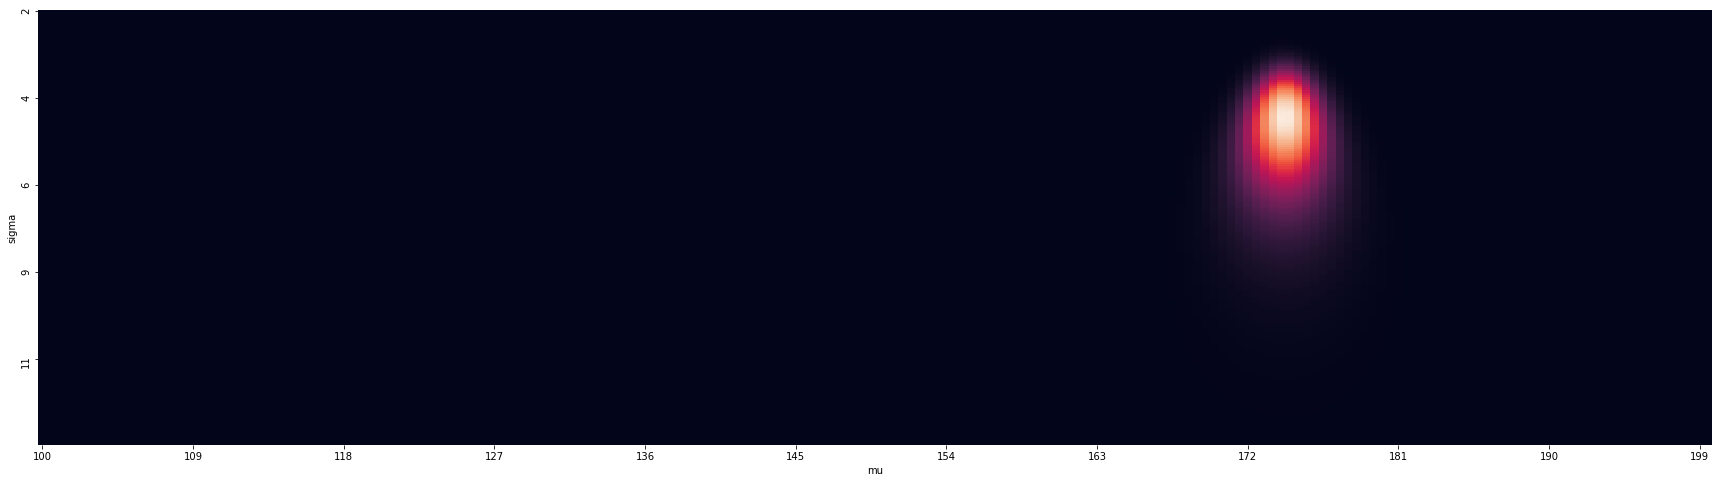

In [137]:
mu_candidates = np.linspace(100,200,200)
sigma_candidates = np.linspace(2,14,200)
t = time.time()
results1 = list(compute_posteriors(mu_candidates, sigma_candidates, data_h, prior1, likelihood1))
print(time.time()-t)
h1 = get_heatmap(results1)
sns.heatmap(h1,xticklabels=18,yticklabels=40,cbar=False)
plt.show()

We can see a bad prior influence on the result for results2 (with prior1bis). Here our normal prior for the mean is very informative (with a variance of 1 for the prior normal law for the mean). In this case do not confuse the variance of the mean's prior normal law and the variance of the normal law describing the distribution of heights.

7.564034938812256
mu(max_posterior) : 165.8291457286432
sigma(max_posterior) : 165.8291457286432
max_posterior : 1.5155273762432545e-18


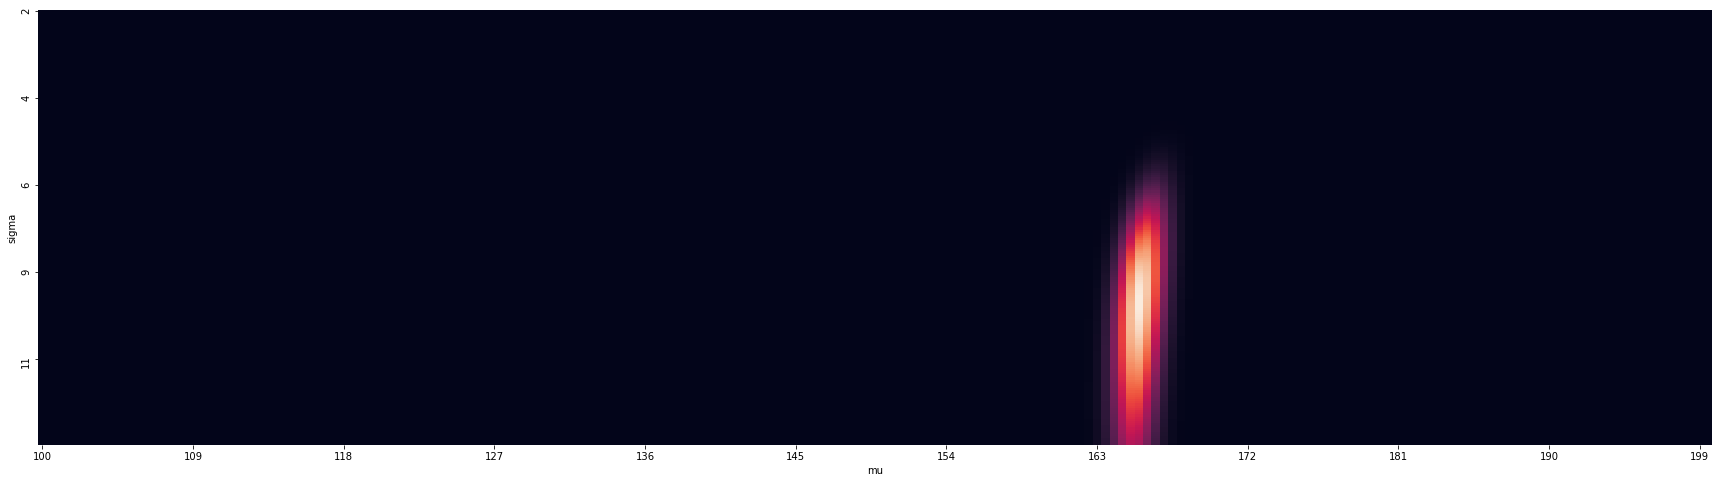

In [138]:
t = time.time()
results2 = list(compute_posteriors(mu_candidates, sigma_candidates, data_h, prior1bis, likelihood1))
print(time.time()-t)
h2 = get_heatmap(results2)
sns.heatmap(h2,xticklabels=18,yticklabels=40,cbar=False)
plt.show()

Here is a less informative prior but that does not conveys false information (but it is still nonetheless more informative than the prior1). 

11.09813404083252
mu(max_posterior) : 174.3718592964824
sigma(max_posterior) : 174.3718592964824
max_posterior : 1.481798735947499e-16


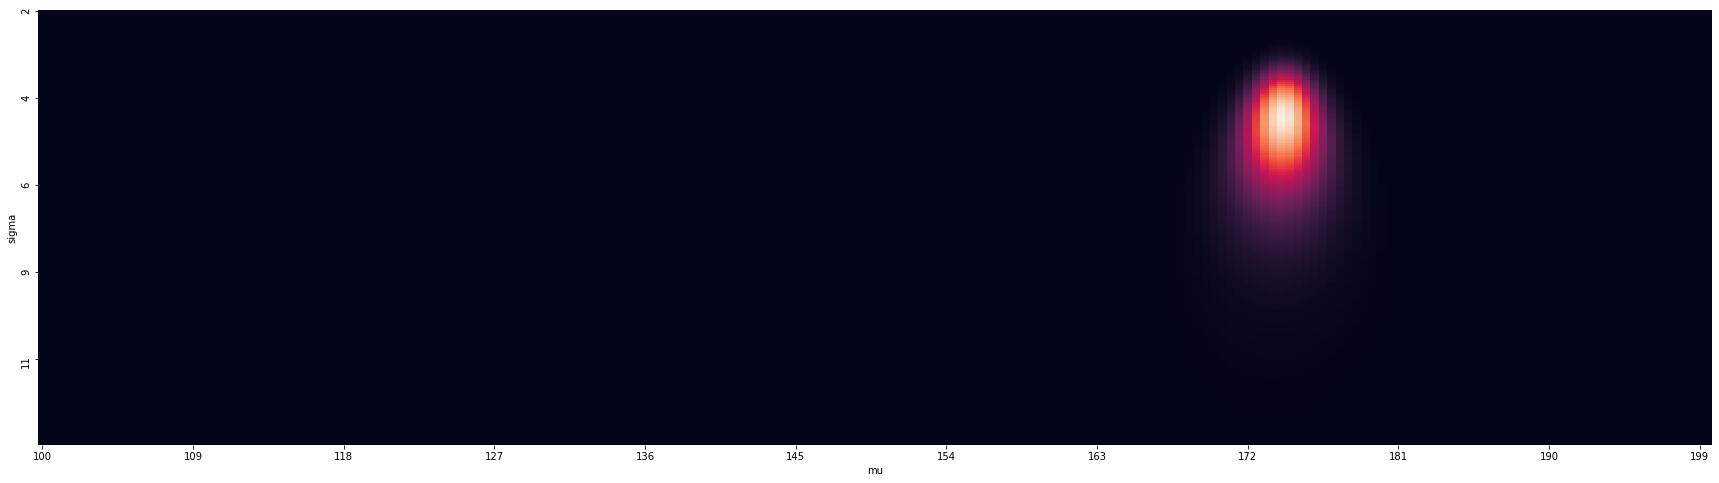

In [139]:
t = time.time()
results3= list(compute_posteriors(mu_candidates, sigma_candidates, data_h, prior1ter, likelihood1))
print(time.time()-t)
h3= get_heatmap(results3)
sns.heatmap(h3,xticklabels=18,yticklabels=40,cbar=False)
plt.show()

In general bayesian inference efficiency will depend on :
- the choice of the prior : subjective choice
- the complexity to compute the posteriori : depends on the size of the data and the complexity of the likelihood function

The efficiency of the grid method can be judged through :
- the resolution of our grid : it means a more precise representation of the posteriori density but more calculus.
- the extension of the grid : the choice is as subjective as the choice of the prior, to be careful you have to choose a large grid but it also means that you will need a greater resolution to capture the form of the density (so more calculus).

In our case : we had to calculate $200*200=40000$ posteriors. Let's note that a solution to avoid the problems of the grid methods (choice of grid and resolution), an alternative is to sample from the prior distribution. The indicated method for this MCMC, we will see why in the following part. 

#### Comparison with frequentist inference

We are going to maximize the likelihood. We can very simply derive the maximum likelihood from our bayesian inference with a uniform prior. In deed, in the case of uniform prior, the maximum a posteriori is equal to maximum likelihood estimator. 

$$\text{max}_{\theta}(P(Y \mid \theta))=\text{max}_{\theta}(P(\theta \mid Y))$$ 

Let's note that there are more rapid means to obtain the maximum likelihood by doing a gradient descent. So frequentist will be more rapid than bayesian inference. 

##### Credible vs Confidence interval

TODO

### 3. Conclusion

> Important points : 
> - Bayesian posteriors have complex expressions and it hard to know on what domain and in which resolution to compute it : Sampling is the solution we will describe after with MCMC. 
> - Frequentist and bayesian inference differences : bayesian inference yields a distribution which is versatile and easy to interpret and frequentist yields a point estimate + confidence intervals and hypothesis testing. 
> - Frequentist and bayesian inference similitudes : in the case of a uniform prior in bayesian MAP (maximum a posteriori) and MLE (maximum likelihood estimator) are equal.

Why we need MCMC ? With the 2D $\theta$ considered here, the times of calculus are not yet prohibitive. But imagine, we have 10 dimensions and we want a resolution of 200 in each dimensions, we will have $200^{8}$ times more important calculus time. (We have here 10 seconds of calculus, so with a 10 dimensions $\theta$, it will be approximately 8 trillions of centuries to finish our calculus).

## B. Understanding the Metropolis-Hastings Algorithm

Based on the paper "Understanding the Metropolis-Hastings Algorithm" by Siddhartha CHIBand Edward GREENBERG

### 1. Definition of a probability density

According to [Wikipedia](https://en.wikipedia.org/wiki/Probability_density_function)

A probability density function is most commonly associated with absolutely continuous univariate distributions. A random variable X has density $f_X$, where $f_X$ is a non-negative Lebesgue-integrable function, if:
$\operatorname{Pr}[a \leq X \leq b]=\int_{a}^{b} f_{X}(x) d x$

### 2. Acceptance-rejection sampling
The objective is to generate samples from the absolutely continuous target density : $\pi(x)=f(x)/K$. Where f is an unnormalized density and K an unknown constant. 
The only thing needed is knowing a density h(x) that can be simulated such that it exists c so that $f(x)<=ch(x)$. Then the algorithm is the following. It is not trivial to obtain the domination condition !

In [75]:
def ar_sample(f,h,sample_h,c):
    z = sample_h()
    u = uniform.rvs()
    if u<=f(z)/(c*h(z)):
        return z
    else:
        return ar_sample(f,h,sample_h,c)
        
def ar_samples(f,h,sample_h,c,n):
    samples = []
    for i in range(n):
        samples += [ar_sample(f,h,sample_h,c)]
    return samples

An important implication of the dominance condition is that f and h should be defined on the same domains. For finite domain functions, it is easy to find a working h function (we know how to sample from a uniform distribution for example).

#### Generate samples without A/R

Before using A/R, we saw that we had to know how to sample from a known distribution that is dominant.  We are going to assume here that we know how to sample from a uniform distribution and an exponential distribution. 

#### Simulation of a finite defintion domain density knowing how to sample from a uniform density : triangle distribution
We are going to sample from a triangle distribution assuming we know how to sample from a uniform distribution with scipy.stats.uniform.

In [12]:
def custom_triangular(x,a,b,m):
    if a<m<b:
        if x<a or x>b:
            return 0
        elif x<=m:
            return (x-a)/(m-a)
        else:
            return (x-b)/(m-b)
    else:
        raise Exception('Not a<m<b !')

In this example the distribution will be normalized. It allows us to check if the sampling is correct with a density plot. For unnormalized functions, some functions canbe normalized by explicitly calculating the integral or by calclating the integral with Monte-Carlwhich is quite simple. 

In [13]:
t1 = lambda x : custom_triangular(x,a=0,b=2,m=1)

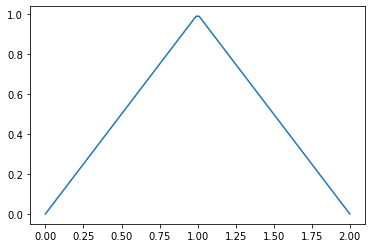

In [14]:
x = np.linspace(0,2,100)
plt.plot(x, [t1(xi) for xi in x])

In [15]:
h1 = lambda x : uniform.pdf(x, loc=0, scale=2)
sample_h1 = lambda : uniform.rvs(loc=0, scale=2)
c1 = 2
s = ar_samples(t1, h1, sample_h1,c1,10000)

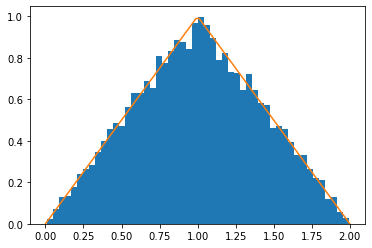

In [16]:
plt.hist(s, bins=50, density=True)
plt.plot(x, [t1(xi) for xi in x])

The choice of c can be important. If c doesn't respect the condition of dominance, the sampling is wrong. And if c is much larger that it could be, there will be more rejections and thus the algorithm will generate the the sample more slowly. 

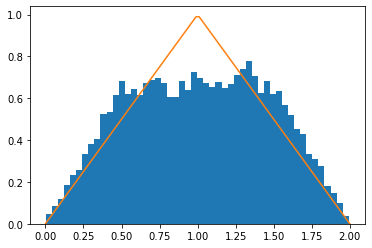

In [17]:
c1 = 1
t = time.time()
s = ar_samples(t1, h1, sample_h1,c1,10000)
plt.hist(s, bins=50, density=True)
plt.plot(x, [t1(xi) for xi in x])

In [18]:
c1 = 2
t = time.time()
s = ar_samples(t1, h1, sample_h1,c1,10000)
print('Time : {}'.format(time.time()-t))
c1 = 4
t = time.time()
s = ar_samples(t1, h1, sample_h1,c1,10000)
print('Time : {}'.format(time.time()-t))

Time : 2.0800392627716064
Time : 4.2950122356414795


The optimal choice for c is $\sup _{x} \frac{f(x)}{h(x)}$.

#### Simulation of a non-finite defintion domain density knowing how to sample from an exponential : normal distribution
We are going to sample from a N(0,1) assuming we know how to sample from an exponential distribution with density $e^{-x}$ with scipy.stats.expon. To obtain any normal distribution we can simply multiply the samples to multiply the variance and add a constant to the sample to add it to the mean. 
By symmetry of the normal density, to generate samples we can generate a sample from :
$f(x)=\frac{2}{\sqrt{2 \pi}} e^{-x^{2} / 2}$ and then set the sign to - with probability 1/2.

For c we have $g(x)=f(x)/f_{exp}(x)=e^{x-x^{2} / 2} \sqrt{2 / \pi}$. By finding the zero of the derivate of g, we have the maximum of g for x=1. So we have $c=g(1)=\sqrt{2 e / \pi}$

In [19]:
const = np.sqrt(2*np.pi)
n1 = lambda x : np.exp((-x**2)/2)*2/const

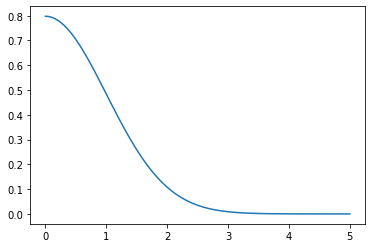

In [20]:
x = np.linspace(0,5,100)
plt.plot(x, [n1(xi) for xi in x])

In [21]:
h2 = lambda x : expon.pdf(x)
sample_h2 = lambda : expon.rvs()
c2 = np.sqrt(2*np.e/np.pi)
s = ar_samples(n1, h2, sample_h2,c2,10000)

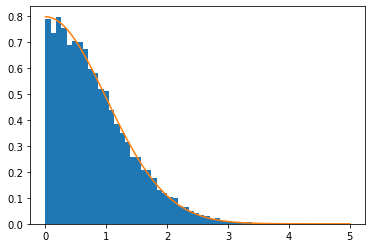

In [22]:
plt.hist(s, bins=50, density=True)
plt.plot(x, [n1(xi) for xi in x])

To obtain the complete sample from N(a,b)

In [65]:
def ar_sample_norm(a,b):
    s = ar_sample(n1, h2, sample_h2,c2)
    if uniform.rvs()<1/2:
        return -b*el+a
    else:
        return b*el+a 

def ar_samples_norm(a,b,n):
    s = ar_samples(n1, h2, sample_h2,c2,n)
    return [-b*el+a if uniform.rvs()<1/2 else b*el+a for el in s]

In [24]:
t = time.time()
s = ar_samples_norm(2,1,10000)
time.time()-t

1.6587028503417969

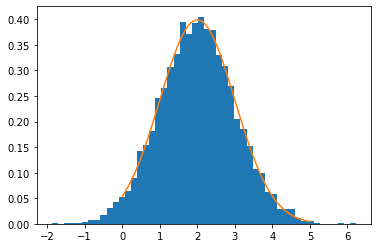

In [99]:
plt.hist(s, bins=50, density=True)
plt.plot(x, [norm.pdf(xi, loc=2, scale=1) for xi in x])

>**A-R allows to sample from a density but it requires to know how to sample from another dominating density. Obtaining the dominance is not always easy as we will see.**

### 3. Markov Chain Monte-Carlo : principle

#### Markov chain

A Markov chain or Markov process is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. (Source : [Wikipedia](https://en.wikipedia.org/wiki/Markov_chain)). Usually Markov chain refers to discrete time Markov chains with a discrete state space. A discrete time discrete state-space markov chain in determined by a stochastic matrix. For example we could imagine a dumb meteo model with a Markov chain model. Imagine there is a transition every day. Each transition has the probability. A remark is that the sum of transitions departing from one state is equal to one. 

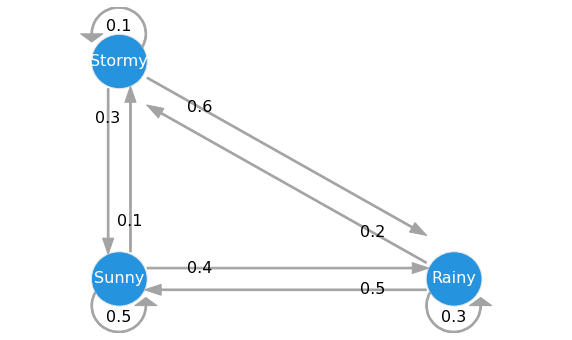

In [13]:
# "Dumb" Markov Chain for the weather

P = np.array([
    [0.5, 0.4, 0.1],
    [0.5, 0.3, 0.2],
    [0.3, 0.6, 0.1],
])
mc = MarkovChain(P, ['Sunny', 'Rainy', 'Stormy']) # Thanks to Naysan Saran : https://github.com/NaysanSaran/markov-chain
mc.draw()

There has been a great deal of research concerning Markov Chains (discrete and other types) with a lot of interesting properties. We are not going here to write book of maths but rather try to develop an intuition on Markov Chain to use it for MCMC.

#### Continuous state-space Markov chains

It is a bit more complicated case than the traditional discrete markov chain. The main difference is that the set of states is continuous. For example, in our last example we could go to any state between rainy and sunny. Let's note here that the time is still discrete ! It is only the state-space that has become continuous. One you understand this notations, you can have a sense of what is going on it a continuous state-space chain :
- Instead of probabilities transition, we have a one step transition density function $p(x,y)$. For example the probability to transit to a state x to somewhere in a set A is $P(x,A)=\int_{\mathcal{A}}P(x, d y) dy$
- We can define n-step transition densities (S is the entire space considered) : $p^{(n)}(x, y)=\int_{\mathcal{S}} p^{(m)}(x, z) \cdot p^{(n-m)}(z, y) d z$ with $p^{(2)}(x, y)=\int_{\mathcal{S}} p(x, z) \cdot p(z, y) d z$ and $p^{(1)}(x, y)=p(x,y)$. This formula gives the density when you go through n steps of the Markov chain. So the probability to go from x to somewhere in A after n steps of the Markov chain is simply : $P^{(n)}(x,A)=\int_{\mathcal{A}}P^{(n)}(x, d y) dy$

As an example of a realization. Let's consider a the jumps of a frog. We can model that the length of the jumps are following a normal law. Then we have : $p(x, y)=\frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^{2}}(y-x)^{2}}$.  

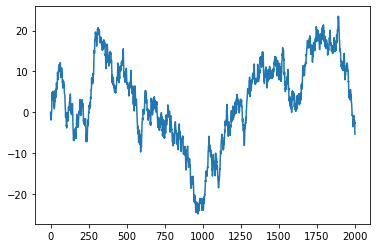

In [25]:
def frog(initial_state, mu, sigma, n):
    state = initial_state
    realization = [initial_state]
    for i in range(n):
        jump = norm.rvs(scale=sigma, loc=mu)
        state += jump
        realization += [state]
    return realization

jumps = frog(0,0,1,2000)
plt.plot(jumps)

>**A markov chain is a stochastic process with description of the probability of transitions between states.**

#### Convergence to invariant distributions
##### Irreducible and aperiodic chains means convergence to a stationary distribution

We are going to to consider the case of continuous state-space Markov chains in MCMC but our examples in this part will in the discrete case to illustrate.

A Markov chain is defined by P(x,A) a transition kernel. It is the probability of moving from a point x to a point in the set A. For example if we are in R, P(x,R)=1 because there is a probability of 1 to move from x to another point in R. It is possible to move from x to {x}. 

It could be interesting to find an invariant distribution. An invariant distribution satisfies : $\pi(y)=\int_{\mathcal{R}^{d}} P(x, y) \pi(x) d x$. It can be shown that under some conditions, if we iterate the Markov Chain, it converges to the invariant distribution .  It is easier to understand this definition in its discrete version with a transition Matrix M. We have $\pi$ the probabilities to transition to each state is invariant if $\pi=\pi M$. The condition to be sure that the chain will converge towards its stationnary distribution is that it is aperiodic and irreducible (from one state, you can go to any other state in a finite set of move). We have exactly the same conditions for the convergence to a stationary distribution in the continuous case.

For example in the discrete case with a Markov chain with a transition Matrix : 

$$
M_0=\left(\begin{array}{ccccc}
\frac{1}{2} & 0 & 0 & 0 & \frac{1}{2} \\
0 & \frac{1}{2} & 0 & \frac{1}{2} & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} \\
\frac{1}{2} & 0 & 0 & 0 & \frac{1}{2}
\end{array}\right)
$$

It can be proven solving the condition of invariance that : $\pi=(a, 0, b, 0, a)$ with $2*a+b=1$.
So we can deduce that the Markov chain will converge to a distribution of that type. If we look closely the Markov chain is stucked at state 0 and 4 or at state 2. So the two only possible converging invariant distribution are (1/2,0,0,0,1/2) and (0,0,1,0,0). It depends on the value of the first element. We have this kind of behavior because this finite Markov chain is reducible. 

Let's consider the following transition Matrix when it is aperiodic and irreducible. Basically, it means that all states are connected (the chain never remains stucked)

$$
M_1=\left(\begin{array}{ccccc}
\frac{1}{2} & 0 & \frac{1}{4} & 0 & \frac{1}{4} \\
0 & \frac{1}{2} & 0 & \frac{1}{2} & 0 \\
0 & 0 & \frac{3}{4} & 0 & \frac{1}{4} \\
0 & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} & \frac{1}{4} \\
\frac{1}{4} & 0 & \frac{1}{4} & 0 & \frac{1}{2}
\end{array}\right)
$$

In this case, we observe that the chain converges each time to same stationnary distribution. We can see that because if we plot the empirical frequencies (histogram) we obtain almost the same probabilities for each state, it converges the same way for any starting state.

In [37]:
def iterate_markov(M, state):
    elements = list(range(len(M)))
    transitions = M[state]
    return np.random.choice(elements, 1, p=transitions)[0]

def n_iterate_markov(M, initial_state, n):
    state = initial_state
    states = [initial_state]
    for i in range(n):
        state = iterate_markov(M, state)
        states += [state]
    return states

(array([8.3740e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.5097e+04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.6529e+04]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

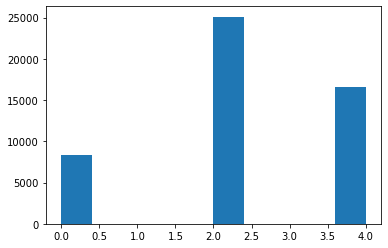

In [96]:
M1 = np.array([[1/2,0,1/4,0,1/4],[0,1/2,0,1/2,0],[0,0,3/4,0,1/4],[0,1/4,1/4,1/4,1/4],[1/4,0,1/4,0,1/2]])
initial_state = 3
s_markov1 = n_iterate_markov(M1, initial_state, 50000)
plt.hist(s_markov1)

In [35]:
def get_proba(s,M):
    size = len(M)
    tot = len(s)
    res = [0]*size
    for el in s:
        res[el] += 1
    for i in range(size):
        res[i] = res[i]/tot
    return res

In [98]:
pi1 = get_proba(s_markov1, M1)
pi1

[0.16683316683316685, 0.0, 0.4855144855144855, 0.0, 0.34765234765234765]

> **To sum up : If there is an invariant distribution. And if the chain is irreducible and aperiodic : it will converge to that invariant distribution.**

##### Reversibility implies invariance

Another notion is important. A distribution could be reversible for a Markov chain. It means :
- $\pi(i)P_{i,j}=\pi(j)P_{j,i}$ in the discrete case
- $\pi(x)p(x,y)=\pi(y)p(y,x)$ in the continuous case
The reversibility implies the invariance. 

Let's verify the reversibility for M1. 

In [54]:
def verify_reversibility(M, pi):
    l = len(M)
    res = M.copy()
    for i in range(l):
        for j in range(l):
            res[i,j] = pi[i]*M[i,j]-pi[j]*M[j,i]
    return res

In [99]:
res1 = verify_reversibility(M1, pi1)
res1

array([[ 0.        ,  0.        ,  0.04170829,  0.        , -0.0452048 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.04170829,  0.        ,  0.        ,  0.        ,  0.03446553],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.0452048 ,  0.        , -0.03446553,  0.        ,  0.        ]])

We can see that in this case, the Markov chain has a distribution that is stationary but not reversible. Let's consider :

$$
M_2=\left(\begin{array}{cccc}
0 & \frac{1}{2} & \frac{1}{2} & 0  \\
\frac{1}{2} & 0 & \frac{1}{2} & 0 \\
\frac{1}{3} & \frac{1}{3} & 0 &\frac{1}{3}  \\
0 & 0 & 1 & 0 \\
\end{array}\right)
$$

It is reversible and thus stationnary.

(array([12474.,     0.,     0., 12484.,     0.,     0., 18754.,     0.,
            0.,  6289.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

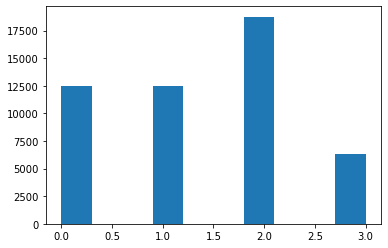

In [81]:
M2 = np.array([[0,1/2,1/2,0],[1/2,0,1/2,0],[1/3,1/3,0,1/3],[0,0,1,0]])
initial_state = 2
s_markov2 = n_iterate_markov(M2, initial_state, 50000)
plt.hist(s_markov2)

In [85]:
pi2 = get_proba(s_markov, M)
pi2

[0.24947501049979, 0.24967500649987, 0.375072498550029, 0.125777484450311]

In [86]:
pi2 = [1/4,1/4,3/8,1/8] # we round up the values of pi2
res2 = verify_reversibility(M2, pi2)
res2

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

>**Reversibility implies invariance.**

#### Markov chain Monte-Carlo with Metropolis-Hastings

The idea of MCMC is to use a kernel function p(x,y) such that it is reversible with the $\pi$ we want to simulate.Then is will converge to $\pi$. It inspired of the A/R method because :
- you choose a transition kernel
- at each transition you accept or reject the transition with a certain probability to verifiy th e reversibility condition.

Say that we want to draw samples from $\pi(x)$.
Given a candidate transition kernel q(x,y), we will have either $\pi(x)q(x,y)>\pi(y)q(y,x)$ or $\pi(x)q(x,y)<\pi(y)q(y,x)$. The majority of the time the reversibility is not verified. But we can correct that by computing each time a probability $\alpha(x,y)$ to stay at the same state. So in practice we are going to use the kernel density : p(x,y) = q(x,y)$\alpha(x,y)$.

The question is : how to obtain  $\pi(x)q(x,y)\alpha(x,y)=\pi(y)q(y,x)\alpha(y,x)$ ?

Let's consider the two cases :
- We have $\pi(x)q(x,y)>\pi(y)q(y,x)$. Our goal is to make the probability to transition smaller. So we can choose $\alpha(y,x)=1$ and $\alpha(x,y)=\pi(y)q(y,x)/\pi(x)q(x,y)$.
- We have $\pi(x)q(x,y)<\pi(y)q(y,x)$. Our goal is to make the probability to transition bigger. So we can choose $\alpha(x,y)=1$. Since $\alpha(y,x)$ will be computed in the same way, we will have the reversibility. 

We can resume the choise of $\alpha(x,y)$ by :

$$
\begin{aligned}
\alpha(x, y) &=\min \left[\frac{\pi(y) q(y, x)}{\pi(x) q(x, y)}, 1\right], & & \text { if } \pi(x) q(x, y)>0 \\
&=1, & & \text { otherwise. }
\end{aligned}
$$

Some additional remarks about the process to understand:
- The probability to make the move $\alpha(x,y)$ is calculated after drawing a from the candidate density q(x,y)
- In practice this probability to move is simulated by simply comparing a draw from a uniform distribution with the vaue of $\alpha(x,y)$. If it is inferior to the draw, we make the move. 
- If the draw indicates that we do not do the move, the next sample is x (we stay at the same state). And then we can redraw from the candidate density and repeat.
- The choice of the candidate density could be arbitrary but some choices have advantages like choosing a symmetric distribution. In this case : q(x,y)=q(y,x). And so the probability of move $\alpha(x,y)$ is simply $\pi(y)/\pi(x)$.

In [164]:
def metropolis(pi, q, draw_from_q, initial_sample, n):
    x = initial_sample
    res = [x]
    for i in range(n):
        y = draw_from_q(x)
        div = (pi(x)*q(x,y))
        if div == 0:
            alpha = 1
        else:
            alpha = min((pi(y)*q(y,x))/div,1)
        u = uniform.rvs()
        if u<=alpha:
            x = y 
        res+= [x]
    return res

In this example, we are going to assume we know how to draw samples from an multivariate distribution with a diagonal covariance (independance of the covariates and thus it only consists in sampling from two normal distributions in 2D). 

In [169]:
def pi(x):
    return multivariate_normal.pdf(x, mean=[1,2], cov=[[1,0.9],[0.9,1]])
    
def q(x,y):
    return multivariate_normal.pdf(x-y, mean=[0,0], cov=[[1,0],[0,1]])

def draw_from_q(x):
    return x+multivariate_normal.rvs(mean=[0,0], cov=[[1,0],[0,1]])

In [170]:
t = time.time()
res = metropolis(pi, q, draw_from_q, [0,0],50000)
time.time()-t

16.882272243499756

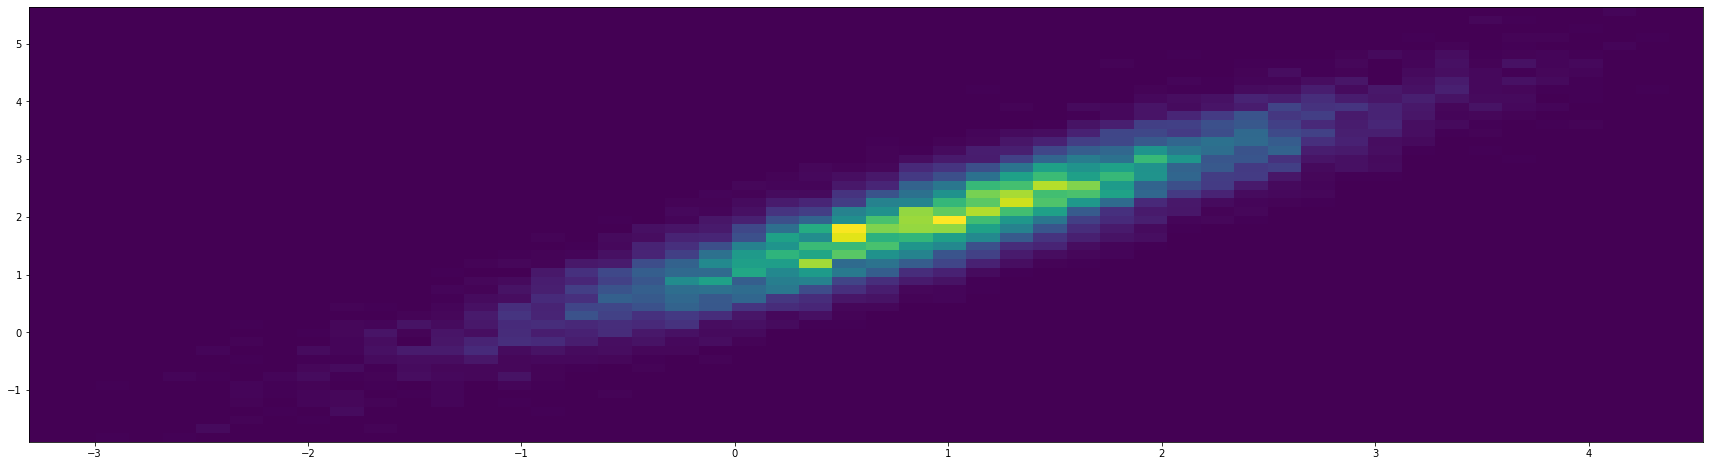

In [171]:
res = np.array(res)
plot = plt.hist2d(res[:,0],res[:,1],bins=50)

To realize what were the advantages of MCMC, let's compare with the same algorithm but using A-R. We are going to assume, like for the MCMC,that we can draw samples from an multivarite with independant variates. The challenge here, that we did not have to care about with MCMC is to find the dominance constant c. It is not straightforward to find it. We should find the maximum of the ratio of two multivariate laws. It could be possible but we will not do it here. 

### 4. MCMC for Bayesian Inference

Like said in the part on bayesian inference. We need a sampling strategy because computing the posterior is not feasible in the case of the simultaneous estimation of several parameters. A-R is not adapted to this case because it is hard to find the dominance of a posterior distribution whose expression is very complex (the calculus of the likelihood results in a product that is the size of the data). 

#### On the example of heights

This example has been applied naively without MCMC in the part that concerns bayesian inference. The candidate transition kernel has to be two dimensional, so will choose a multivariate with variance (2,0.5) and we will begin our walk at (100, 1). Note that it is a bad start and we will have to let our MCMC converge.  

In [198]:
data_h = np.array([183, 168, 177, 170, 175, 177, 178, 166, 174, 178])

def get_posterior(theta, data_h, prior, likelihood):
    if theta[1]>0: # the probability to have a negative or 0 variance is null
        posterior = prior(theta)
        likelihoods = likelihood(data_h, theta)
        for i in range(len(data_h)):
            posterior = likelihoods[i]*posterior
        return posterior
    else: 
        return 0
    
def prior2(theta):
    return norm.pdf(theta[0],loc=165,scale=14)*uniform.pdf(theta[1],loc=2,scale=12)

def likelihood2(h, theta):
    return norm.pdf(h,loc=theta[0],scale=theta[1])

def pi2(theta):
    return get_posterior(theta, data_h, prior2, likelihood2)

def q2(theta1,theta2):
    return multivariate_normal.pdf(theta1-theta2, mean=[0,0], cov=[[2,0],[0,0.5]])

def draw_from_q2(theta):
    return theta+multivariate_normal.rvs(mean=[0,0], cov=[[2,0],[0,0.5]])

t = time.time()
res2 = metropolis(pi2, q2, draw_from_q2, np.array([100,1]),4000)
time.time()-t

2.3000621795654297

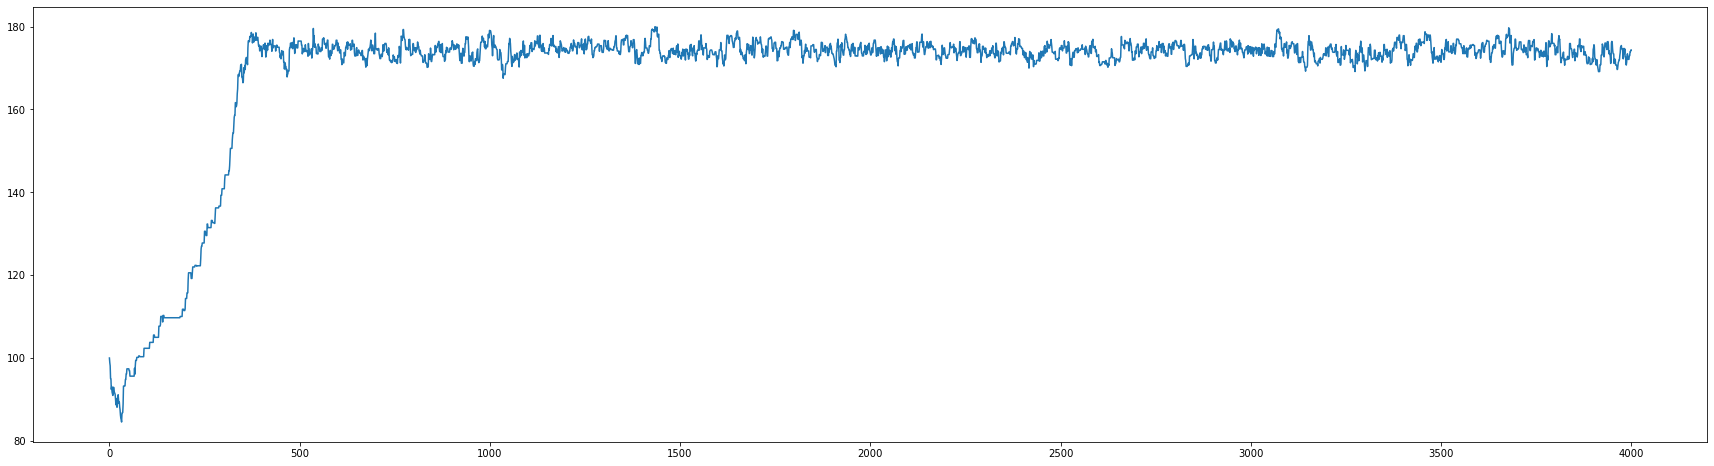

In [199]:
res2 = np.array(res2)
plt.plot(res2[:,0])

We can see that the chains seems to stabilize at 500. We can burn the first 500 samples.

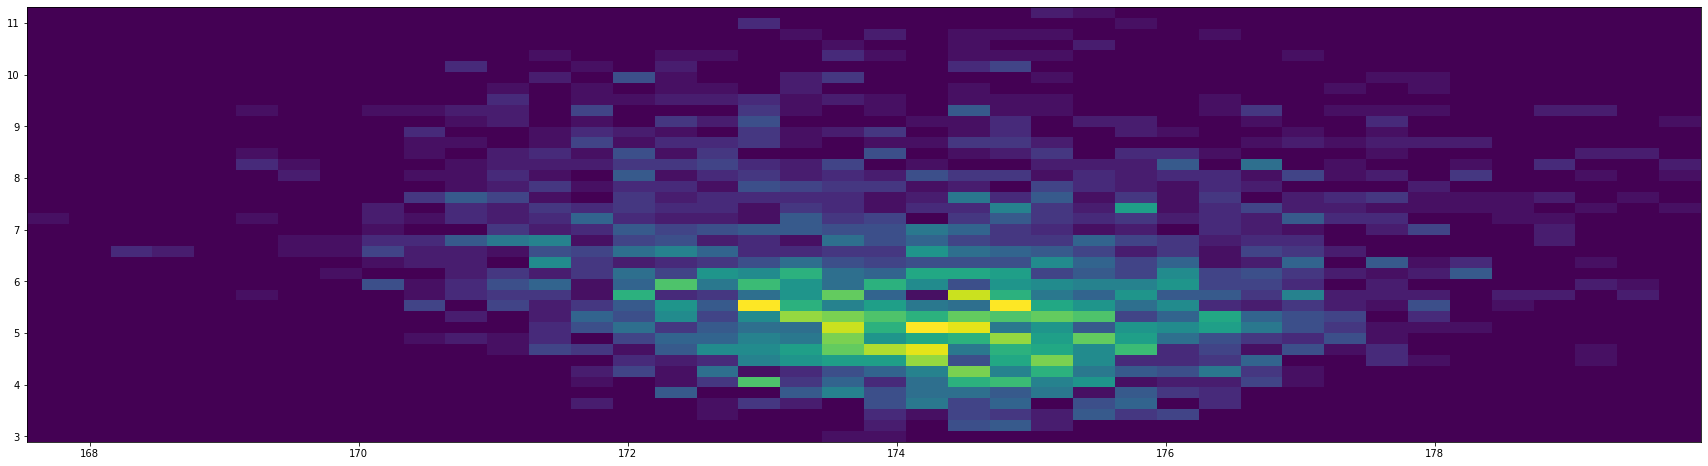

In [200]:
plot = plt.hist2d(res2[500:,0],res2[500:,1],bins=40)

The advantage over the evaluation of the posterior is not clear here. What we can see is that the sampling does not make necessary the choice of the resolution and the size of the grid a variable, we only have to choose how much samples to burn. The advantage is clear in the case for higher dimensions and in cases where the choice of resolutions and size of the grid is difficult. 

Two notes : 
- In this case the choice to evaluate the values of the posterior (grid method) is feasible and thus it has the advantage to yield the true values of the posterior directly (values that are proportional to the true posterior). The MCMC only converges to the distribution. 
- But an advantage of MCMC is that if we want to have a better representation, we only have to make more samples whereas with the evaluation of the posterior we would have calculate everything from the begining or make a grid pattern exploration that allows an incremental augmentation of the resolution. 

#### On another more complex example

We have observations of the model : $y_{t}=\phi_{1} y_{t-1}+\phi_{2} y_{t-2}+\epsilon_{t}$. Where 
- $\phi_{1}=1$
- $\phi_{1}=-0.5$
- $\epsilon_{t} \sim N(0,1)$

The goal is to find the values of $\phi$ that are supposed to be unknown. 

In [73]:
# Let's generate the observations

def generate_observations(n=100, y0=1, y1=1):
    res = [y0,y1]
    yt1 = y1
    yt2 = y0
    for i in range(n):
        noise = norm.rvs()
        yt = yt1-0.5*yt2+noise
        res += [yt]
        yt2 = yt1
        yt1 = yt
    return res

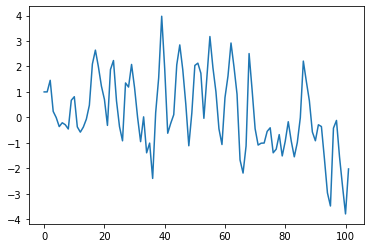

In [74]:
obs = generate_observations()
plt.plot(obs)

The likelihood